<a href="https://colab.research.google.com/github/kushsharma2910/FGQ/blob/kush/normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

Using TensorFlow backend.


In [0]:
#######################################################################################
################################# CREATING LARGEDF  ###################################
#######################################################################################

def change_index_to_time(df):
    if "Time (UTC)" in df.columns:
      df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'])
      df.set_index('Time (UTC)', inplace = True, drop = True)
    
#Finds the dataframe with largest number of time stamps and returns an empty dataframe with same index
def create_empty_df(dir_name):
    largest_timeframe = 0
    path_to_largest = ""

    for asset_class in os.listdir(dir_name):
        for asset in os.listdir(dir_name +  "/" + asset_class):    
            df = pd.read_csv(dir_name +  "/" + asset_class + "/" + asset)
            if df.shape[0] > largest_timeframe:
                largest_timeframe = df.shape[0]
                path_to_largest = dir_name +  "/" + asset_class + "/" + asset

    largest_dataframe = pd.read_csv(path_to_largest)
    change_index_to_time(largest_dataframe)
    largest_dataframe = pd.DataFrame(index = largest_dataframe.index)
    return largest_dataframe

#######################################################################################
################################# FEATURE BUILDING  ###################################
#######################################################################################

def fill_large_df(dir_name, large_df):
    asset67 = []
    for asset_class in os.listdir(dir_name):
        for asset in os.listdir(dir_name +  "/" + asset_class): 
            extract_name = asset.split("_")
            asset67.append(extract_name[0][:-4])
            df = pd.read_csv(dir_name +  "/" + asset_class + "/" + asset)
            change_index_to_time(df)
            large_df = large_df.join(df)
            rename_dic = {}
            for column in df.columns:    
                rename_dic[column] = column + "@" + extract_name[0][:-4]
            large_df = large_df.rename(columns = rename_dic) 
            
    return large_df, asset67

def add_lag_features(only_feat_df):
  lag_feat = only_feat_df.copy()
  BASE_FEATURES = ["Open@" + target_asset, "High@" + target_asset, "Low@" + target_asset, "Close@" + target_asset]
  N_WINDOW = [64, 128, 256, 512]
  prevlag = 1 
  for window in N_WINDOW:
    rolled = lag_feat[BASE_FEATURES].shift(prevlag).rolling(window=window)
    lag_feat = lag_feat.join(rolled.mean().add_suffix(f'_window_{window}_mean'))
    lag_feat = lag_feat.join(rolled.max().add_suffix(f'_window_{window}_max'))
    lag_feat = lag_feat.join(rolled.min().add_suffix(f'_window_{window}_min'))
    lag_feat = lag_feat.join(rolled.std().add_suffix(f'_window_{window}_std'))
  return lag_feat

def remove_spread(df, target_asset):
    target_asset_spread = []
    features = ["Open", "High", "Low", "Close", "Volume "]

    for feature in features:
        target_asset_spread.append(feature + "_spread@" + target_asset)

    remove_columns = []
    for column in df.columns:
        if (column not in target_asset_spread) and ("spread" in column):
            remove_columns.append(column)

    df = df.drop(columns = remove_columns)
    return df

def denoise_fft(df, target_asset, level):
    features = ["Open@" + target_asset, "High@" + target_asset, "Low@" + target_asset, "Close@" + target_asset]
    
    for feature in features:
        close_fft = np.fft.fft(np.asarray(df[feature].tolist()))
        fft_df = pd.DataFrame({'fft':close_fft})
        fft_list = np.asarray(fft_df['fft'].tolist())
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[level:-level] = 0
        df[feature] = np.real(np.fft.ifft(fft_list_m10))

def extract_features(large_df, target_asset, target_window, asset67, \
                    add_lag = False, keep_spread = True):
    df = large_df.copy()

    #Try using denoise for all the features
    #not only for OHLC target_asset
    # if denoise == True:
    #     level = 2000
    #     denoise_fft(df, target_asset, level)

    #remove the spread columns of assets
    #other than the target asset
    if keep_spread == False:
        df = remove_spread(df, target_asset)

    #comment out this line if you 
    #don't want to use the lag features
    if add_lag == True:
      df = add_lag_features(df)

    df["H-" + str(target_window) + "hr" ] = df.pop("H-" + str(target_window) + "hr@" + target_asset)
    df["L-" + str(target_window) + "hr" ] = df.pop("L-" + str(target_window) + "hr@" + target_asset)
    
    #removing targets of assets other
    # than the target assset
    for asset in asset67:
        if asset != target_asset:
            df = df.drop(columns = ["H-4hr@" + asset, "L-4hr@" + asset, "H-12hr@" + asset,
                               "L-12hr@" + asset, "H-24hr@" + asset,"L-24hr@" + asset])
            
    #this loop asserts that labels for target asset is
    #not present for other windows
    windows = ["4", "12", "24"]
    for window in windows:
      if window != str(target_window):
        high = "H-" + window + "hr@" + target_asset
        low = "L-" + window + "hr@" + target_asset
        if high in df.columns:
          df = df.drop(columns = [high])
        if low in df.columns:
          df = df.drop(columns = [low])

    change_index_to_time(df)        
    return df

def normalize_df(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def standard_df(df):
    result = df.copy()
    for feature_name in df.columns:
        df[feature_name] = (df[feature_name]-df[feature_name].mean()) / df[feature_name].std()
    return result

def denoise_df(df, level):
    for feature_name in df.columns[:-1]:
        close_fft = np.fft.fft(np.asarray(df[feature_name].tolist()))
        fft_df = pd.DataFrame({'fft':close_fft})
        fft_list = np.asarray(fft_df['fft'].tolist())
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[level:-level] = 0
        df[feature_name] = np.real(np.fft.ifft(fft_list_m10))
    return df

#######################################################################################
################################# MODEL BUILDING  #####################################
#######################################################################################


#predicting the H as previous value
def create_baseline(only_feat_df, direction, target_window):     
    preds = np.array(pd.Series(only_feat_df[direction + "-" + str(target_window) + "hr"]).shift(1).bfill(axis = 0))
    actual = np.array(only_feat_df[direction + "-" + str(target_window) + "hr"])
    return preds, actual

#######################################################################################
############################# ACCURACY CALCULATIONS  ##################################
#######################################################################################

def acc_abs(preds, actual, tolerance):
    tolerance /= 100
    score = 0
    for ix in range(preds.shape[0]):
        if np.abs(preds[ix] - actual[ix]) / actual[ix] <= tolerance:
            score += 1
    return score / preds.shape[0]

def acc_dir(preds, actual, tolerance, direction):
    tolerance /= 100
    score = 0
    for ix in range(preds.shape[0]):
        if actual[ix] > preds[ix]*(1+tolerance)  and direction == "H":
            score += 1
        elif actual[ix] < preds[ix]*(1-tolerance)  and direction == "L":
             score += 1
    return score / preds.shape[0]

def min_pips(preds, actual, opens, tolerance, pips, direction):
    pips /= 100
    tolerance /= 100
    score = 0
    for ix in range(preds.shape[0]):
        if preds[ix] < actual[ix]*(1+tolerance)  and (direction == "H" and (actual[ix] - opens[ix])>=pips):
            score += 1 
        elif preds[ix] > actual[ix]*(1+tolerance)  and (direction == "L" and (opens[ix] - actual[ix])>=pips):
             score += 1
    return score / preds.shape[0]

In [0]:
#name of the root directory which contains asset classes which further contain asset csv ask and bid pairs
# dir_name = "drive/My Drive/FGQ/Assets"
# large_df = create_empty_df(dir_name)

In [0]:
#asset67 contains the 67 selected assets which have data for more than 6 years
# large_df_, asset67 = fill_large_df(dir_name, large_df)

In [0]:
#Filling in previous values for values in middle
# large_df_ = large_df_.ffill(axis=0)

#Filling in next value for initial nan values
#This is used for assets which do not have initial data
# large_df_ = large_df_.bfill(axis=0)

In [7]:
#When using google drive

#to extract to the home dir
!unzip "drive/My Drive/FGQ/large_df_.zip"
large_df_ = pd.read_csv("large_df_.csv")

#List of assets present in large_df_
asset67 = np.array(pd.read_csv("drive/My Drive/FGQ/asset67.csv").iloc[:, 1])

Archive:  drive/My Drive/FGQ/large_df_.zip
  inflating: large_df_.csv           


In [0]:
#input variables
target_asset = "XAGUSD"
target_window = 12
direction = "L"
#give tolerance in percent
tolerance = 0.5
#in the xlsx file, first row and columns have been removed for efficient reading
pip_xl = pd.read_excel("drive/My Drive/FGQ/Labels to Forecast.xlsx")

#querying pips
pips = pip_xl[pip_xl["Label"] == target_asset][str(target_window) + " Hour"].values[0]

only_feat_df = extract_features(large_df_, target_asset, target_window, asset67, add_lag=False, keep_spread=False)

In [0]:
# preds, actual = create_baseline(only_feat_df, direction, target_window)

# #calculate accuracies
# print(acc_abs(preds, actual, tolerance))
# print(acc_dir(preds, actual, tolerance, direction))
# print(min_pips(preds, actual, only_feat_df["Open@" + target_asset], tolerance, pips, direction))

In [9]:
features = ["Open@" + target_asset, "High@" + target_asset, "Low@" + target_asset, "Close@" + target_asset,
            direction + "-" + str(target_window) + "hr"]

# corr1 = "XAUUSD"
# corr2 = "USA500IDXUSD"

# features = []
# for feature in only_feat_df.columns:
#     if target_asset in feature or corr1 in feature or corr2 in feature: 
#         features.append(feature)
# features.append(direction + "-" + str(target_window) + "hr")

only_norm = only_feat_df[features]
# only_norm = denoise_df(only_norm, 5000)
# only_norm = standard_df(only_feat_df[features])

#using only half training data for faster training
split = int(0.5 * only_norm.shape[0])
only_norm = only_norm.iloc[:split, :]

print(only_norm.shape)
print(only_norm.columns)

(62363, 5)
Index(['Open@XAGUSD', 'High@XAGUSD', 'Low@XAGUSD', 'Close@XAGUSD', 'L-12hr'], dtype='object')


In [0]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)

params = {
    "batch_size": 1024, 
    "epochs": 150,
    "lr": 0.00001000,
    "time_steps": 256
}

OUTPUT_PATH = "drive/My Drive/FGQ/models/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

def trim_dataset(x_t,batch_size):
    no_of_rows_drop = x_t.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return x_t[:-no_of_rows_drop]
    else:
        return x_t

def build_timeseries(only_norm):
    # Y = (only_norm["Close@" + target_asset] - only_norm[direction + "-" + str(target_window) + "hr"]) / only_norm["Close@" + target_asset]
    # Y = (2*Y - Y.min(axis=0) - Y.max(axis=0)) / (Y.max(axis=0) - Y.min(axis=0))
    # Y = (Y - Y.min(axis=0)) / (Y.max(axis=0) - Y.min(axis=0))

    Y = only_norm[direction + "-" + str(target_window) + "hr"]

    dim_0 = only_norm.shape[0] - TIME_STEPS
    dim_1 = only_norm.shape[1]-1

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    close_prices = np.zeros((dim_0, ))
    open_prices = np.zeros((dim_0, ))
    target_prices = np.zeros((dim_0, ))

    copy = only_norm.copy()

    for i in tqdm_notebook(range(dim_0)):
        x[i] = normalize_df(copy.iloc[i:TIME_STEPS+i, :-1])
        y[i] = (Y[TIME_STEPS+i] - copy["Close@" + target_asset].iloc[TIME_STEPS+i-1]) / copy["Close@" + target_asset].iloc[TIME_STEPS+i-1]
        close_prices[i] = copy["Close@" + target_asset].iloc[TIME_STEPS+i-1]
        open_prices[i] = copy["Open@" + target_asset].iloc[TIME_STEPS+i]
        target_prices[i] = Y[TIME_STEPS+i]
        # y[i] = Y[TIME_STEPS+I]
    
    y = (2*y - y.min(axis=0) - y.max(axis=0)) / (y.max(axis=0) - y.min(axis=0))

    return x, y, close_prices, open_prices, target_prices

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.1, recurrent_dropout=0.1, stateful=True, return_sequences=True,
                        kernel_initializer='zeros'))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(25))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(16))
    lstm_model.add(BatchNormalization())
    lstm_model.add(LeakyReLU(alpha=0.1))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(1, activation = "linear"))

    optimizer = optimizers.Adam(lr=params["lr"])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [41]:
df_train, df_test = train_test_split(only_norm, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

x_t, y_t, close_prices_t, open_prices_t, target_prices_t = build_timeseries(df_train)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
close_prices_t = trim_dataset(close_prices_t, BATCH_SIZE)
open_prices_t = trim_dataset(open_prices_t, BATCH_SIZE)
target_prices_t = trim_dataset(target_prices_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

x_temp, y_temp, close_prices_temp, open_prices_temp, target_prices_temp  = build_timeseries(df_test)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
close_prices_val, close_prices_test_t = np.split(trim_dataset(close_prices_temp, BATCH_SIZE),2)
open_prices_val, open_prices_test_t = np.split(trim_dataset(open_prices_temp, BATCH_SIZE),2)
target_prices_val, target_prices_test_t = np.split(trim_dataset(target_prices_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Train--Test size 49890 12473



Batch trimmed size (49152, 256, 4) (49152,)



Test size (5632, 256, 4) (5632,) (5632, 256, 4) (5632,)


In [0]:
model = create_model()

In [92]:
r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=300, 
                                  verbose=0, mode='auto', min_delta=0, cooldown=0, min_lr=0.00001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=300, min_delta=0)
    
mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                        "best_model.h5"), monitor='val_loss', verbose=1,
                        save_best_only=True, save_weights_only=False, mode='min', period=1)

csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)

history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger, r_lr_plat])

Train on 49152 samples, validate on 5120 samples
Epoch 1/150
 - 40s - loss: 0.0779 - val_loss: 0.0294

Epoch 00001: val_loss improved from inf to 0.02940, saving model to drive/My Drive/FGQ/models/best_model.h5
Epoch 2/150
 - 40s - loss: 0.0774 - val_loss: 0.0267

Epoch 00002: val_loss improved from 0.02940 to 0.02674, saving model to drive/My Drive/FGQ/models/best_model.h5
Epoch 3/150
 - 40s - loss: 0.0773 - val_loss: 0.0280

Epoch 00003: val_loss did not improve from 0.02674
Epoch 4/150
 - 40s - loss: 0.0768 - val_loss: 0.0269

Epoch 00004: val_loss did not improve from 0.02674
Epoch 5/150
 - 40s - loss: 0.0762 - val_loss: 0.0267

Epoch 00005: val_loss improved from 0.02674 to 0.02668, saving model to drive/My Drive/FGQ/models/best_model.h5
Epoch 6/150
 - 41s - loss: 0.0767 - val_loss: 0.0256

Epoch 00006: val_loss improved from 0.02668 to 0.02563, saving model to drive/My Drive/FGQ/models/best_model.h5
Epoch 7/150
 - 40s - loss: 0.0761 - val_loss: 0.0250

Epoch 00007: val_loss impro

KeyboardInterrupt: ignored

In [0]:
best_model = load_model("drive/My Drive/FGQ/models/best_model.h5")

In [0]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
open_prices_test_t = trim_dataset(open_prices_test_t, BATCH_SIZE)
close_prices_test_t = trim_dataset(close_prices_test_t, BATCH_SIZE)
target_prices_test_t = trim_dataset(target_prices_test_t, BATCH_SIZE)

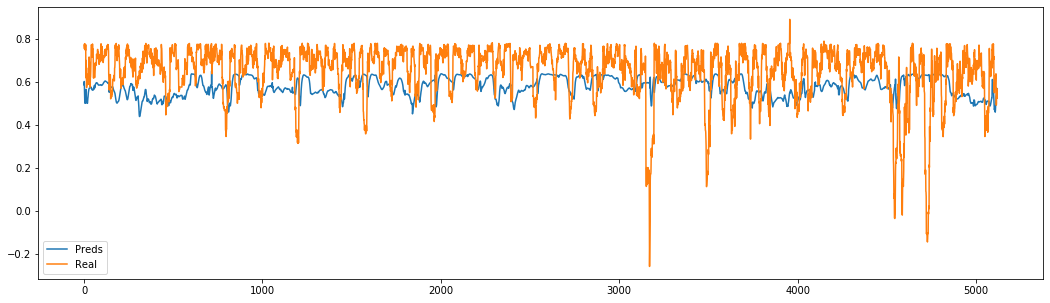

In [157]:
plt.figure(figsize = (18, 5))
plt.plot(y_pred[:], label = "Preds")
plt.plot(y_test_t[:], label = "Real")
plt.legend()
plt.show()

In [0]:
refer = (target_prices_test_t - close_prices_test_t) / close_prices_test_t
ma = refer.max(axis = 0)
mi = refer.min(axis = 0)

y_test_t_inverse = ((y_test_t * (ma - mi)) + mi + ma) / 2
y_pred_inverse = ((y_pred * (ma - mi)) + mi + ma) / 2
smooth_pred_inverse = ((smooth_pred * (ma - mi)) + mi + ma) / 2

y_org = target_prices_test_t
y_org_p = ((y_pred_inverse) + 1) * close_prices_test_t

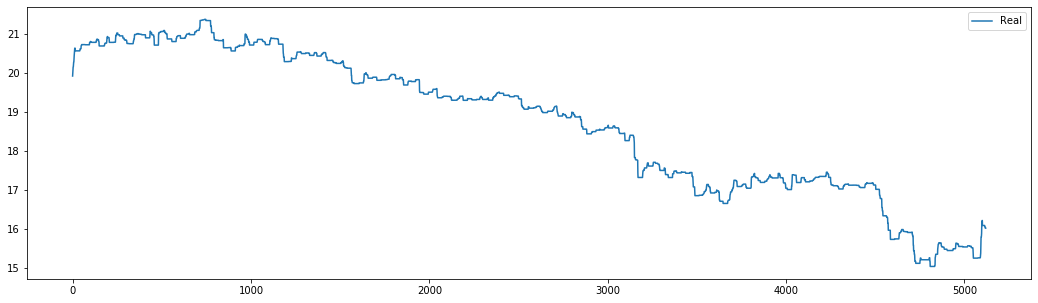

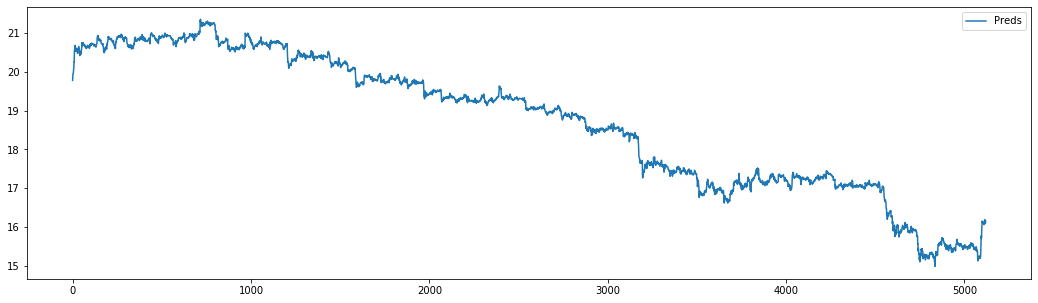

In [159]:
plt.figure(figsize = (18, 5))
plt.plot(y_org, label = "Real")
plt.legend()
plt.show()

plt.figure(figsize = (18, 5))
plt.plot(y_org_p, label = "Preds")
plt.legend()
plt.show()

In [160]:
tolerance = 0.5
print(acc_abs(y_org_p, y_org, tolerance))

0.603515625
